In [1]:
import os

import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, LinExpr, quicksum
import collections

# DCNDP 1

In [2]:
# Def to get a graph in file format .edgelist or .gml, given a file-path
def get_graph(path: str):
    if path.endswith('.edgelist'):
        return nx.read_edgelist(path=path, nodetype=int)
    else:
        return nx.read_gml(path=path, label='id')

In [21]:
G = get_graph('data/Real_networks/Sanjuansur2.edgelist')

In [22]:
N = G.number_of_nodes()
C = int(0.05 * N)
k = 3

In [23]:
# global variable
cut_count = 0
bound_check = 0
global bound_save

### Define the modified cut callback with the BFS implementation

In [24]:
def first_depth_k_bfs(input_graph: nx.Graph, cost: dict, connect: dict, k_value: int, cut_limit: int, model: Model):
    global cut_count
    roots = [n for (n, attr) in cost.items() if attr == 0]
    for root in roots:
        # keep track of all visited nodes and nodes to be checked
        visited, queue = {root}, collections.deque([root])
        # this dict keeps track of levels
        levels = {root: 0}
        # this dict keeps track of predecessors
        predecessor = {root: -1}
        cut_count = 0

        # keep looping until there are no nodes still to be checked
        while queue:
            if cut_count > cut_limit:
                break
            # pop first node from the queue
            vertex = queue.popleft()
            for neighbour in input_graph[vertex]:
                # only consider neighbors with solution=0
                if neighbour not in visited and cost[neighbour] <= 1e-5:
                    new_level = levels[vertex] + 1
                    # direct neighbours of root node
                    if new_level == 1:
                        predecessor[neighbour] = vertex
                        levels[neighbour] = new_level
                        # mark neighbours of node as visited to avoid revisiting
                        visited.add(neighbour)
                        # add neighbours of node to queue
                        queue.append(neighbour)

                    # new_level in range(2,k)
                    elif new_level in range(2, k_value):
                        predecessor[neighbour] = vertex
                        levels[neighbour] = new_level
                        # mark neighbours of node as visited to avoid revisiting
                        visited.add(neighbour)
                        # add neighbours of node to queue
                        queue.append(neighbour)
                        i = min([root, neighbour])
                        j = max([root, neighbour])
                        if connect[(i, j)] < 1 - 1e-5:
                            model.cbLazy(
                                model._x_delete[neighbour] + model._x_delete[vertex] +
                                model._x_delete[root] + model._u_connect[i, j] >= 1)
                            cut_count += 1

                    elif new_level == k_value:
                        predecessor[neighbour] = vertex
                        levels[neighbour] = new_level
                        # mark neighbours of node as visited to avoid revisiting
                        visited.add(neighbour)
                        # add neighbours of node to queue
                        queue.append(neighbour)
                        i = min([root, neighbour])
                        j = max([root, neighbour])
                        if connect[(i, j)] < 1 - 1e-5:
                            model.cbLazy(
                                model._x_delete[neighbour] + model._x_delete[vertex] +
                                model._x_delete[predecessor[vertex]] + model._x_delete[root] + model._u_connect[
                                    i, j] >= 1)
                            cut_count += 1

                    else:  # new_level >k
                        # print("required depth reached")
                        break
            else:
                continue
            break

In [25]:
def second_depth_k_bfs(input_graph: nx.Graph, cost: dict, connect: dict, root: dict,
                       k_value: int, cut_limit: int, model: Model):
    global cut_count
    # keep track of all visited nodes and nodes to be checked
    visited, queue = {root}, collections.deque([root])
    # this dict keeps track of levels
    levels = {root: 0}
    # this dict keeps track of distance label sum of lp-solution value of each node along the path
    dist_label = {root: cost[root]}

    # this dict keeps track of predecessor
    predecessor = {root: -1}
    cut_count = 0

    # keep looping until there are no nodes still to be checked
    while queue:
        if cut_count > cut_limit:
            # print("cutlimit reached")
            return
        # pop first node from the queue
        vertex = queue.popleft()
        # order the set of neighbors according to LP-relaxation solution
        for neighbour in sorted(input_graph[vertex], key=lambda x: input_graph.nodes[x]['LPsol']):
            # for neighbour in input_graph[vertex]:
            if neighbour not in visited:  # and cost[neighbour]==0:
                new_level = levels[vertex] + 1
                # levels[neighbour]= levels[vertex]+1
                if new_level == 1:
                    predecessor[neighbour] = vertex
                    dist_label[neighbour] = dist_label[vertex] + cost[neighbour]
                    levels[neighbour] = new_level
                    # mark neighbours of node as visited to avoid revisiting
                    visited.add(neighbour)
                    # add neighbours of node to queue
                    queue.append(neighbour)

                elif new_level in range(2, k_value):  # new_level in range(2,k)
                    predecessor[neighbour] = vertex
                    dist_label[neighbour] = dist_label[vertex] + cost[neighbour]
                    levels[neighbour] = new_level
                    # mark neighbours of node as visited to avoid revisiting
                    visited.add(neighbour)
                    # add neighbours of node to queue
                    queue.append(neighbour)
                    i = min([root, neighbour])
                    j = max([root, neighbour])
                    if dist_label[neighbour] + connect[(i, j)] < 1 - 1e-5:
                        model.cbLazy(model._x_delete[neighbour] + model._x_delete[vertex] + model._x_delete[root] +
                                     model._u_connect[i, j] >= 1)
                        cut_count += 1

                elif new_level == k_value:
                    predecessor[neighbour] = vertex
                    dist_label[neighbour] = dist_label[vertex] + cost[neighbour]
                    levels[neighbour] = new_level
                    # mark neighbours of node as visited to avoid revisiting
                    visited.add(neighbour)
                    # add neighbours of node to queue
                    queue.append(neighbour)
                    i = min([root, neighbour])
                    j = max([root, neighbour])
                    if dist_label[neighbour] + connect[(i, j)] < 1 - 1e-5:
                        model.cbLazy(
                            model._x_delete[neighbour] + model._x_delete[vertex] +
                            model._x_delete[predecessor[vertex]] +
                            model._x_delete[root] + model._u_connect[i, j] >= 1)
                        cut_count += 1

                else:  # new_level >k
                    # print("required depth reached")
                    break
        else:
            continue
        break

In [26]:
def cut(model, where):
    global bound_check, node_count, bound_save
    cost = {}
    connect = {}

    if where == GRB.Callback.MIPSOL:
        # get MIPSOL_OBJBDN = Current best objective bound
        bound_save = model.cbGet(GRB.callback.MIPSOL_OBJBND)
        # get MIPSOL_NODCNT = Current explored node count
        current_explored_node_count = model.cbGet(GRB.Callback.MIPSOL_NODCNT)
        for j in G.nodes():
            # retrieve values from the new MIP solution
            cost[j] = abs(model.cbGetSolution(model._x_delete[j]))
            for i in G.nodes():  # range(ind, j):
                if i < j:
                    connect[(i, j)] = abs(model.cbGetSolution(model._u_connect[i, j]))
        if current_explored_node_count == 0:
            first_depth_k_bfs(G, cost, connect, k, GRB.INFINITY, model)
        else:
            first_depth_k_bfs(G, cost, connect, k, 150, model)

    # Currently exploring a MIP node
    elif where == GRB.Callback.MIPNODE:  # if relaxed solution
        # Optimization status of current MIP node if it is OPTIMAL
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.Status.OPTIMAL:
            # get current best objective bound
            current_best_obj_bound = model.cbGet(GRB.callback.MIPNODE_OBJBND)
            # get current explored node count
            current_explored_node_count = int(model.cbGet(GRB.callback.MIPNODE_NODCNT))
            if bound_save == current_best_obj_bound:
                bound_check += 1
                if bound_check >= 5 and current_explored_node_count > 0:
                    bound_check = 0
                else:
                    for j in G.nodes():
                        cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                        G.nodes[j]['LPsol'] = cost[j]  # set node attributes to lp solution
                        for i in G.nodes():
                            if i < j:
                                # retrieve values from the node relaxation solution at the current node
                                connect[(i, j)] = abs(model.cbGetNodeRel(model._u_connect[i, j]))

                    roots = [n for (n, attr) in cost.items() if attr < 1]
                    for rt_node in roots:
                        second_depth_k_bfs(G, cost, connect, rt_node, k, 150, model)

            else:
                bound_save = current_best_obj_bound
                for j in G.nodes():
                    cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                    G.nodes[j]['LPsol'] = cost[j]  # set node attributes to lp solution
                    for i in G.nodes():  # range(ind, j):
                        if i < j:
                            connect[(i, j)] = abs(model.cbGetNodeRel(model._u_connect[i, j]))

                roots = [n for (n, attr) in cost.items() if attr < 1]
                for rt_node in roots:
                    second_depth_k_bfs(G, cost, connect, rt_node, k, 150, model)

## Gurobi Model Implementation

### Define the variables
$$
x_{i} = \begin{cases}
  1, \quad if \; node \, i \, is \, deleted \\
  0, \quad if \; otherwise \\
\end{cases}
\\
\\
y_{i,j} = \begin{cases}
  1, \quad if \; (i,j) \, \, are \, connected \, by \,  a \, path \, \leq k \, in \, G^r\\
  0, \quad otherwise \\
\end{cases}
$$

### Model DCMDP 1
$$
Min. \quad \sum_{i,j \in V : i < j} y_{i,j}
\\
\\
\sum_{i \in V} x_{i} \leq B
\\
\\
\sum_{r \in V(P)} x_{r} + y_{i,j} \geq 1, \quad \forall P \in P_{k}(i,j), \quad (i,j) \in V, \quad i<j
\\
\\
x_{i} \in {0,1}, \quad \forall v \in V
\\
\\
y_{i,j} \in {0,1}, \quad \forall (i,j) \in V, \quad i<j

$$

In [27]:
def minimize_dcnp(input_graph: nx.Graph, C: float):
    model = Model('Minimize distance -based pairwise connectivity of distance at most k ')
    # variables
    x_delete = {}
    u_connect = {}
    for j in input_graph.nodes():
        # The node degree is the number of edges adjacent to the node.
        if input_graph.degree[j] == 1:
            x_delete[j] = model.addVar(lb=0.0, ub=0.0, vtype=GRB.BINARY, name=f'x[{j}]')
        else:
            x_delete[j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=f'x[{j}]')
        # connectivity variables
        for i in input_graph.nodes():
            if i < j:
                u_connect[i, j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=f'u[{i},{j}]')

    # objective
    obj = LinExpr(0)
    for j in input_graph.nodes():
        for i in input_graph.nodes():  # range(ind, j):
            if i < j:
                obj.add(u_connect[i, j])

    # constraint on number of critical nodes
    model.addConstr(sum((x_delete[j]) for j in input_graph.nodes()) <= C, name='3.30')

    # constraints on connectivity variables u
    # constraints on (i,j) in E
    for (i, j) in input_graph.edges():
        if i < j:
            model.addConstr(u_connect[i, j] + x_delete[i] + x_delete[j] >= 1, name="3.29")
        else:  # that is j<i
            model.addConstr(u_connect[j, i] + x_delete[j] + x_delete[i] >= 1, name="3.29_2")

    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model._x_delete = x_delete
    model._u_connect = u_connect
    model.setParam(GRB.param.Cuts, 0)
    model.setParam(GRB.param.PreCrush, 1)
    model.setParam('LazyConstraints', 1)
    model.setParam('TimeLimit', 10800)
    model.optimize(cut)
    run_time = model.Runtime
    x_delete_val = model.getAttr('x', x_delete)

    critical_nodes = [i for i in x_delete_val.keys() if x_delete_val[i] >= 1 - 1e-4]
    return critical_nodes, obj.getValue(), run_time, model

### Get the result and plot the graph

In [28]:
# find the critical nodes
critical_nodes, opt_obj, run_time, model =  minimize_dcnp(G, C)
print(f'N nodes: {G.number_of_nodes()}')
print(f'N nodes: {G.number_of_edges()}')
print(f'Diameter: {nx.diameter(G)}')
print('percentage distance-based pairwise connectivity = {:.2f}%'.format(
    2 * 100 * opt_obj / (G.number_of_nodes() * (G.number_of_nodes() - 1))))
print(f'cos: {C}')
print(f'num vars: {model.getAttr(GRB.Attr.NumVars)}')
print("critical nodes are :", critical_nodes)
print("Running Time = {:.2f} seconds".format(run_time))
print('distance-based pairwise connectivity = {:.2f} nodes'.format(opt_obj))
print(model.getAttr(GRB.Attr.ObjBound))
print(f'Status {model.getAttr(GRB.Attr.Status)}')

Set parameter Cuts to value 0
Set parameter PreCrush to value 1
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 156 rows, 2850 columns and 540 nonzeros
Model fingerprint: 0x822c0729
Variable types: 0 continuous, 2850 integer (2850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 156 rows, 2849 columns, 538 nonzeros
Variable types: 0 continuous, 2849 integer (2849 binary)

Root relaxation: objective 5.230000e+02, 1080 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0

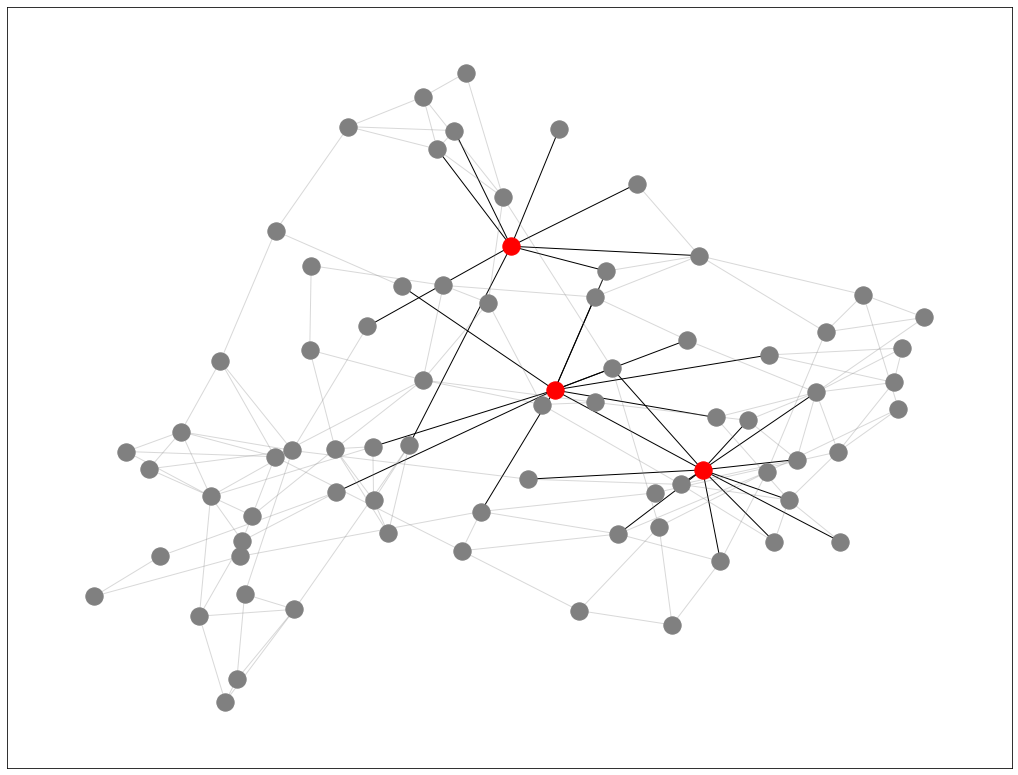

In [29]:
# split edges and nodes for drawing
removed_edges = [(i, j) for (i, j) in G.edges() if (i in critical_nodes or j in critical_nodes)]
remaining_edges = [(i, j) for (i, j) in G.edges() if (i, j) not in removed_edges]
remaining_nodes = [i for i in G.nodes() if i not in critical_nodes]
pos = nx.spring_layout(G, k=0.15)  # spring parameter k
plt.figure(figsize=[18, 14])
nx.draw_networkx_nodes(G, pos, nodelist=critical_nodes, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=remaining_nodes, node_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='k')
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray', alpha=0.3)
plt.show()

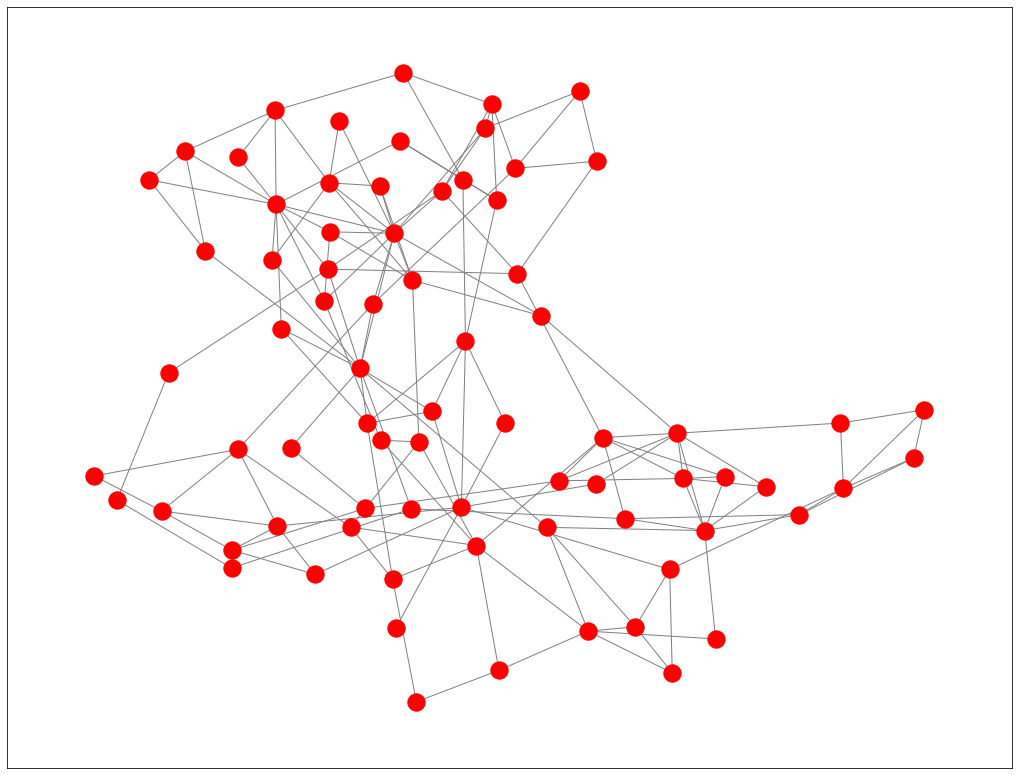

In [30]:
edges = [(i, j) for (i, j) in G.edges()]
nodes = [i for i in G.nodes()]
nodes.sort()
edges.sort()
pos = nx.spring_layout(G, k=0.15)  # spring parameter k
plt.figure(figsize=[18, 14])
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')
plt.show()